In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
#filter out to only have top 10 tags
ten_tags=['sd', 'b', 'sv', 'aa', '%', 'ba', 'qy', 'x', 'ny', 'fc']

In [4]:
#get all of the text features as dataframes
train_text_features= pd.read_csv('/content/drive/MyDrive/data_sets_v2/text_features_train.csv')
valid_text_features= pd.read_csv('/content/drive/MyDrive/data_sets_v2/text_features_valid.csv')
test_text_features= pd.read_csv('/content/drive/MyDrive/data_sets_v2/text_features_test.csv')

#only want da_tags from top 10
train_filtered_text_features = train_text_features[train_text_features['da_tag'].isin(ten_tags)]
valid_filtered_text_features = valid_text_features[valid_text_features['da_tag'].isin(ten_tags)]

In [5]:
#get all of speech features as dataframes
train_speech_features=pd.read_csv('/content/drive/MyDrive/data_sets_v2/speech_features_train.csv')
test_speech_features=pd.read_csv('/content/drive/MyDrive/data_sets_v2/speech_features_test.csv')
valid_speech_features=pd.read_csv('/content/drive/MyDrive/data_sets_v2/speech_features_valid.csv')

#only want da_tags from top 10
train_filtered_speech_features = train_speech_features[train_speech_features['da_tag'].isin(ten_tags)]
valid_filtered_speech_features = valid_speech_features[valid_speech_features['da_tag'].isin(ten_tags)]

In [6]:
#merge text and speech into one new dataframe
test_filtered_all_features = pd.merge(test_text_features, test_speech_features.drop(columns=['transcript', 'da_tag']), on=['dialog_id', 'speaker', 'start_time', 'end_time']).drop(columns=['Unnamed: 0'])
train_filtered_all_features = pd.merge(train_filtered_text_features, train_filtered_speech_features.drop(columns=['transcript', 'da_tag']), on=['dialog_id', 'speaker', 'start_time', 'end_time']).drop(columns=['Unnamed: 0'])
valid_filtered_all_features = pd.merge(valid_filtered_text_features, valid_filtered_speech_features.drop(columns=['transcript', 'da_tag']), on=['dialog_id', 'speaker', 'start_time', 'end_time']).drop(columns=['Unnamed: 0'])

In [11]:
test_filtered_all_features

,dialog_id,speaker,transcript,da_tag,start_time,end_time,function,pronoun,ppron,i,...,Min Intensity,Max Intensity,Mean Intensity,Speaking Rate,Jitter,Shimmer,HNR,Mean F1,Mean F2,Mean F3
0,sw2019,A,SIL,NaN,0.00000,2.92922,0.000000,0.000000,0.000000,0.0,...,23.602756,79.827500,70.917882,1.024163,0.000312,0.034769,21.438803,704.773375,1219.697315,2269.949425
1,sw2019,B,SIL,NaN,0.00000,4.46754,0.000000,0.000000,0.000000,0.0,...,28.177052,78.716378,71.187587,0.671510,0.000000,0.000000,6.178681,909.641925,1746.564187,2557.623304
2,sw2019,A,uh do you have a pet randy,NaN,2.92922,4.31867,0.571429,0.142857,0.142857,0.0,...,23.915646,74.111609,65.186494,18.712440,0.009214,0.141815,8.222078,524.945407,1526.087381,2248.210630
3,sw2019,A,SIL,NaN,4.31867,6.74838,0.000000,0.000000,0.000000,0.0,...,26.542937,67.124739,57.868742,1.234715,0.008221,0.134172,7.171753,497.943840,1484.815192,2249.593722
4,sw2019,B,uh yeah,NaN,4.46754,5.01339,0.000000,0.000000,0.000000,0.0,...,63.055445,82.494241,78.551585,12.824036,0.005994,0.152243,3.183084,690.640641,1462.493432,2309.716309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23535,sw4936,B,yeah,NaN,294.02342,294.43437,0.000000,0.000000,0.000000,0.0,...,34.064575,52.474904,48.302825,9.733544,0.004654,0.073020,7.892052,526.809268,1725.204125,2460.052014
23536,sw4936,B,SIL,NaN,294.43437,297.07133,0.000000,0.000000,0.000000,0.0,...,-337.381678,29.352794,20.051064,1.137674,0.001668,0.240857,-2.028997,1126.362494,1597.369412,2315.003035
23537,sw4936,A,SIL,NaN,296.74224,299.04000,0.000000,0.000000,0.000000,0.0,...,16.219428,42.414339,33.663947,1.305619,0.019332,0.122348,4.857124,436.025215,1585.122595,2387.780951
23538,sw4936,B,yeah,NaN,297.07133,297.19119,0.000000,0.000000,0.000000,0.0,...,40.392162,43.096970,42.338514,33.372268,0.013308,0.129447,5.941313,479.144616,1810.361424,2566.940535


In [15]:
#TEXT FEATURES

#Separate features and labels for train, validation, and test, dont want identifying columns
def prepare_data(dataset):
    X = dataset.drop(columns=['da_tag', 'dialog_id', 'speaker', 'transcript', 'start_time', 'end_time'])
    y = dataset['da_tag']
    return X, y

#get train, test and validation datasets without identifying columns
def occupy_data(train, valid, test):
    X_train, y_train = prepare_data(train)
    X_val, y_val = prepare_data(valid)
    X_test = test.drop(columns=['da_tag', 'dialog_id', 'speaker', 'transcript', 'start_time', 'end_time'], errors='ignore')
    y_test = None  #No labels yet
    return X_train, y_train, X_val, y_val, X_test, y_test

#get datasets without identifying labels
X_train, y_train, X_val, y_val, X_test, y_test = occupy_data(train_filtered_text_features, valid_filtered_text_features, test_text_features)

#Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

# Check shapes before scaling, make sure non-zero (wasnt filtered out earlier)
print("Shapes before scaling:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

#fill in any missing columns with a 0 so train, test, and val have same feature columns
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

#fit and standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#build MulitLayerPerceptron following GeeksForGeeks guide
def build_mlp_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#Compile and train the model
num_classes = len(label_encoder.classes_)
model = build_mlp_model(input_shape=X_train.shape[1], num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

#Evaluate predictions on validation set using F1 score
y_val_pred = np.argmax(model.predict(X_val), axis=1)
f1_val = f1_score(y_val, y_val_pred, average='macro')
accuracy_val = accuracy_score(y_val, y_val_pred)

print("Validation F1 Score (macro):", f1_val)
print("Validation Accuracy:", accuracy_val)

Shapes before scaling:
X_train: (74111, 1124)
X_val: (19156, 1121)
X_test: (23540, 1120)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7742 - loss: 0.6853 - val_accuracy: 0.8248 - val_loss: 0.5023
Epoch 2/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8346 - loss: 0.4618 - val_accuracy: 0.8274 - val_loss: 0.4959
Epoch 3/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8489 - loss: 0.4276 - val_accuracy: 0.8240 - val_loss: 0.5137
Epoch 4/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8599 - loss: 0.3931 - val_accuracy: 0.8236 - val_loss: 0.5369
Epoch 5/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8726 - loss: 0.3613 - val_accuracy: 0.8205 - val_loss: 0.5645
Epoch 6/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8813 - loss: 0.3416 - val_accuracy: 0.8226 - val_loss: 0.6147
Epoch 7/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8883 - loss: 0.3241 - val_accuracy: 0.8191 - val_loss: 0.6669
Epoch 8/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8931 - loss: 0

In [16]:
#Predict on test set and save predictions
y_test_pred = np.argmax(model.predict(X_test), axis=1)
y_test_pred_labels = label_encoder.inverse_transform(y_test_pred)

#Load test data to align predictions
test_df = pd.read_csv('/content/drive/MyDrive/data_sets_v2/test.csv')

test_text_features['da_tag'] = y_test_pred_labels

if 'da_tag' in test_df.columns:
    test_df = test_df.drop(columns=['da_tag'])

#Merge predictions with original test dataframe
test_df = pd.merge(
    test_df,
    test_text_features[['dialog_id', 'da_tag', 'speaker', 'start_time', 'end_time']],
    on=['dialog_id', 'speaker', 'start_time', 'end_time'],
    how='left'
)

#First three columns (e.g., 'dialog_id', 'speaker', 'transcript')
#Insert 'da_tag' as the fourth column
columns = (
    test_df.columns[:3].tolist() +
    ['da_tag'] +
    [col for col in test_df.columns if col not in test_df.columns[:3].tolist() + ['da_tag']]
)
test_df = test_df[columns]

#Save predictions to CSV
test_df.to_csv('test_cjd2186_text.csv', index=False)
print("Predictions saved to 'test_cjd2186_text.csv'")

736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predictions saved to 'test_cjd2186_text.csv'


In [ ]:
test_df

,dialog_id,speaker,transcript,da_tag,start_time,end_time,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,sw2019,A,SIL,x,0.00000,2.92922,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,sw2019,B,SIL,x,0.00000,4.46754,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,sw2019,A,uh do you have a pet randy,qy,2.92922,4.31867,0.571429,0.142857,0.142857,0.0,0.0,0.142857,0.0,0.0,0.0,0.142857,0.0,0.285714,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.142857,0.0
3,sw2019,A,SIL,x,4.31867,6.74838,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,sw2019,B,uh yeah,b,4.46754,5.01339,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.5,0.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23535,sw4936,B,yeah,b,294.02342,294.43437,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0
23536,sw4936,B,SIL,x,294.43437,297.07133,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
23537,sw4936,A,SIL,x,296.74224,299.04000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
235

In [17]:
#SPEECH FEATURES
def prepare_data(dataset):
    X = dataset.drop(columns=['da_tag', 'dialog_id', 'speaker', 'transcript', 'start_time', 'end_time'])
    y = dataset['da_tag']
    return X, y

def occupy_data(train, valid, test):
    X_train, y_train = prepare_data(train)
    X_val, y_val = prepare_data(valid)
    X_test = test.drop(columns=['da_tag', 'dialog_id', 'speaker', 'transcript', 'start_time', 'end_time'], errors='ignore')
    y_test = None  #No labels yet
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = occupy_data(train_filtered_speech_features, valid_filtered_speech_features, test_speech_features)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

print("Shapes before scaling:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#added extra layer to improve performance
#with standard MLP structure used in text/multi, had F1 score of .24
#by adding extra layer, lowering learning rate, and increasing epochs to 50, improved F1 score to .266
#closer to assignment benchmark of .27
def build_mlp_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_shape,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

num_classes = len(label_encoder.classes_)
model = build_mlp_model(input_shape=X_train.shape[1], num_classes=num_classes)

#add learning rate to improve performance
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

y_val_pred = np.argmax(model.predict(X_val), axis=1)
f1_val = f1_score(y_val, y_val_pred, average='macro')
accuracy_val = accuracy_score(y_val, y_val_pred)

print("Validation F1 Score (macro):", f1_val)
print("Validation Accuracy:", accuracy_val)

Shapes before scaling:
X_train: (74111, 13)
X_val: (19156, 13)
X_test: (23540, 13)
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2316/2316 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6054 - loss: 1.3582 - val_accuracy: 0.7007 - val_loss: 0.9485
Epoch 2/50
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6954 - loss: 0.9463 - val_accuracy: 0.7096 - val_loss: 0.8977
Epoch 3/50
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6998 - loss: 0.9131 - val_accuracy: 0.7124 - val_loss: 0.8794
Epoch 4/50
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7075 - loss: 0.8886 - val_accuracy: 0.7126 - val_loss: 0.8775
Epoch 5/50
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7039 - loss: 0.8833 - val_accuracy: 0.7154 - val_loss: 0.8649
Epoch 6/50
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7070 - loss: 0.8687 - val_accuracy: 0.7171 - val_loss: 0.8590
Epoch 7/50
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7077 - loss: 0.8711 - val_accuracy: 0.7174 - val_loss: 0.8549
Epoch 8/50
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7078 - loss: 0.8674 - val_accu

In [18]:
y_test_pred = np.argmax(model.predict(X_test), axis=1)
y_test_pred_labels = label_encoder.inverse_transform(y_test_pred)

test_df = pd.read_csv('/content/drive/MyDrive/data_sets_v2/test.csv')

test_speech_features['da_tag'] = y_test_pred_labels

if 'da_tag' in test_df.columns:
    test_df = test_df.drop(columns=['da_tag'])

test_df = pd.merge(
    test_df,
    test_speech_features[['dialog_id', 'da_tag', 'speaker', 'start_time', 'end_time']],
    on=['dialog_id', 'speaker', 'start_time', 'end_time'],
    how='left'
)

columns = (
    test_df.columns[:3].tolist() +
    ['da_tag'] +
    [col for col in test_df.columns if col not in test_df.columns[:3].tolist() + ['da_tag']]
)
test_df = test_df[columns]

test_df.to_csv('test_cjd2186_speech.csv', index=False)
print("Predictions saved to 'test_cjd2186_speech.csv'")

736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Predictions saved to 'test_cjd2186_speech.csv'


In [19]:
#BOTH TEXT AND SPEECH
def prepare_data(dataset):
    X = dataset.drop(columns=['da_tag', 'dialog_id', 'speaker', 'transcript', 'start_time', 'end_time'])
    y = dataset['da_tag']
    return X, y

def occupy_data(train, valid, test):
    X_train, y_train = prepare_data(train)
    X_val, y_val = prepare_data(valid)
    X_test = test.drop(columns=['da_tag', 'dialog_id', 'speaker', 'transcript', 'start_time', 'end_time'], errors='ignore')
    y_test = None  #No labels yet
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = occupy_data(train_filtered_all_features, valid_filtered_all_features, test_filtered_all_features)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

print("Shapes before scaling:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)


X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

def build_mlp_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

num_classes = len(label_encoder.classes_)
model = build_mlp_model(input_shape=X_train.shape[1], num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

y_val_pred = np.argmax(model.predict(X_val), axis=1)
f1_val = f1_score(y_val, y_val_pred, average='macro')
accuracy_val = accuracy_score(y_val, y_val_pred)

print("Validation F1 Score (macro):", f1_val)
print("Validation Accuracy:", accuracy_val)

Shapes before scaling:
X_train: (74109, 1136)
X_val: (19154, 1133)
X_test: (23540, 1132)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7748 - loss: 0.6816 - val_accuracy: 0.8262 - val_loss: 0.4909
Epoch 2/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8343 - loss: 0.4554 - val_accuracy: 0.8288 - val_loss: 0.4872
Epoch 3/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8470 - loss: 0.4222 - val_accuracy: 0.8312 - val_loss: 0.5056
Epoch 4/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8603 - loss: 0.3841 - val_accuracy: 0.8263 - val_loss: 0.5216
Epoch 5/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8722 - loss: 0.3535 - val_accuracy: 0.8264 - val_loss: 0.5486
Epoch 6/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8822 - loss: 0.3360 - val_accuracy: 0.8243 - val_loss: 0.5981
Epoch 7/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8885 - loss: 0.3144 - val_accuracy: 0.8247 - val_loss: 0.6278
Epoch 8/20
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8951 - loss: 0

In [20]:
#want label with highest prediction accuracy for each feature
y_test_pred = np.argmax(model.predict(X_test), axis=1)
y_test_pred_labels = label_encoder.inverse_transform(y_test_pred)

test_df = pd.read_csv('/content/drive/MyDrive/data_sets_v2/test.csv')

test_filtered_all_features['da_tag'] = y_test_pred_labels

if 'da_tag' in test_df.columns:
    test_df = test_df.drop(columns=['da_tag'])

test_df = pd.merge(
    test_df,
    test_filtered_all_features[['dialog_id', 'da_tag', 'speaker', 'start_time', 'end_time']],
    on=['dialog_id', 'speaker', 'start_time', 'end_time'],
    how='left'
)

columns = (
    test_df.columns[:3].tolist() +
    ['da_tag'] +
    [col for col in test_df.columns if col not in test_df.columns[:3].tolist() + ['da_tag']]
)
test_df = test_df[columns]

736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [21]:
test_df.to_csv('test_cjd2186_multi.csv', index=False)
print("Predictions saved to 'test_cjd2186_multi.csv'")

Predictions saved to 'test_cjd2186_multi.csv'


In [19]:
test_df

,dialog_id,speaker,transcript,da_tag,start_time,end_time,function,pronoun,ppron,i,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,sw2019,A,SIL,x,0.00000,2.92922,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,sw2019,B,SIL,x,0.00000,4.46754,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,sw2019,A,uh do you have a pet randy,qy,2.92922,4.31867,0.571429,0.142857,0.142857,0.0,...,0.142857,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.142857,0.0
3,sw2019,A,SIL,x,4.31867,6.74838,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,sw2019,B,uh yeah,b,4.46754,5.01339,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.5,0.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23535,sw4936,B,yeah,b,294.02342,294.43437,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0
23536,sw4936,B,SIL,x,294.43437,297.07133,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
23537,sw4936,A,SIL,x,296.74224,299.04000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
23538,sw4936,B,yeah,b,297.07133,297.19119,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0


array(['x', 'x', 'qy', ..., 'x', 'b', 'sv'], dtype=object)

In [22]:
#Confusion Matrix
da_tags=['sd', 'b', 'sv', 'aa', '%', 'ba', 'qy', 'x', 'ny', 'fc']

#Generate the confusion matrix
#Need to decode labels from numbers into actual tags
y_true= label_encoder.inverse_transform(y_val)
y_pred= label_encoder.inverse_transform(y_val_pred)
cm = confusion_matrix(y_true, y_pred, labels=da_tags, normalize=None)

row_cm_normalized = confusion_matrix(y_true, y_pred, labels=da_tags, normalize='true')
column_cm_normalized= confusion_matrix(y_true, y_pred, labels=da_tags, normalize='pred')



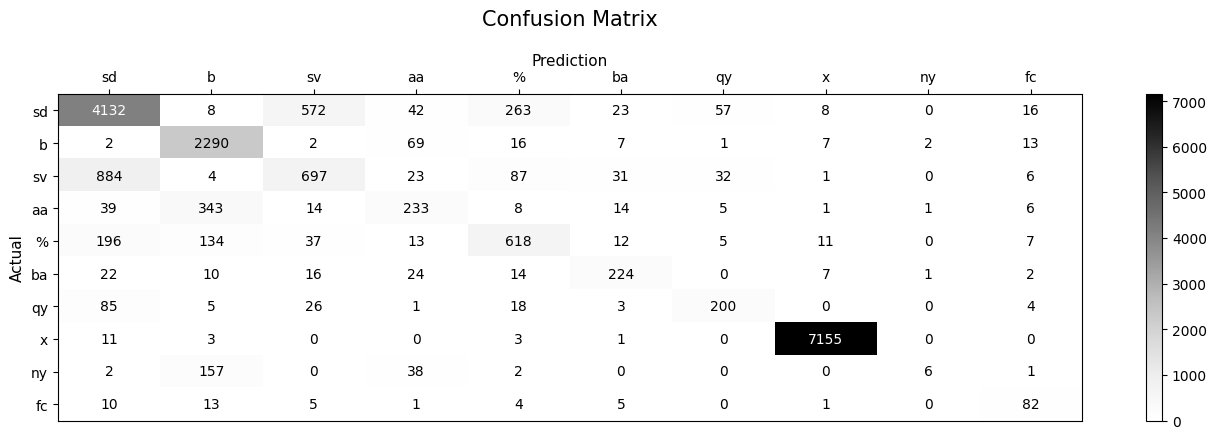

In [23]:
#Follow GeeksForGeeks tutorial on how to generate and plot confusionmatrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=da_tags)
disp.plot(cmap=plt.cm.Greys)

#plt.figure(figsize=(12, 10))

plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)


#get current axis
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().set_aspect('auto')
plt.subplots_adjust(left=12, right=14, bottom=0.2)

plt.show()

#Intepretation Notes
#most confused classes are non-diagonal

#weigh classes to solve confusion
#data augemention to account for weighing

#transfer learning --> pretrained models

#normalized --> ratio of actual/prediction correct
#colns prediction/actual #incorrect

#precision (out of terms predicted) and recall (number of correct labels predicted out of ground truth labels)
#precision: can miss ground truth labels, but want to be correct
#recall: most of ground truth labels to be predicted correctly
#different denominators

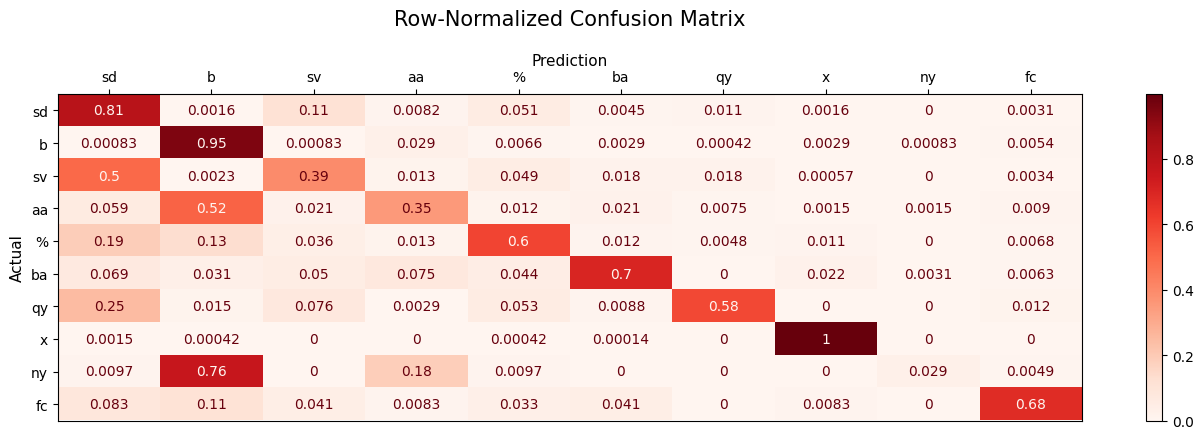

In [24]:
cm=row_cm_normalized
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=da_tags)
disp.plot(cmap=plt.cm.Reds)


plt.title('Row-Normalized Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)


#get current axis
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().set_aspect('auto')
plt.subplots_adjust(left=12, right=14, bottom=0.2)

plt.show()

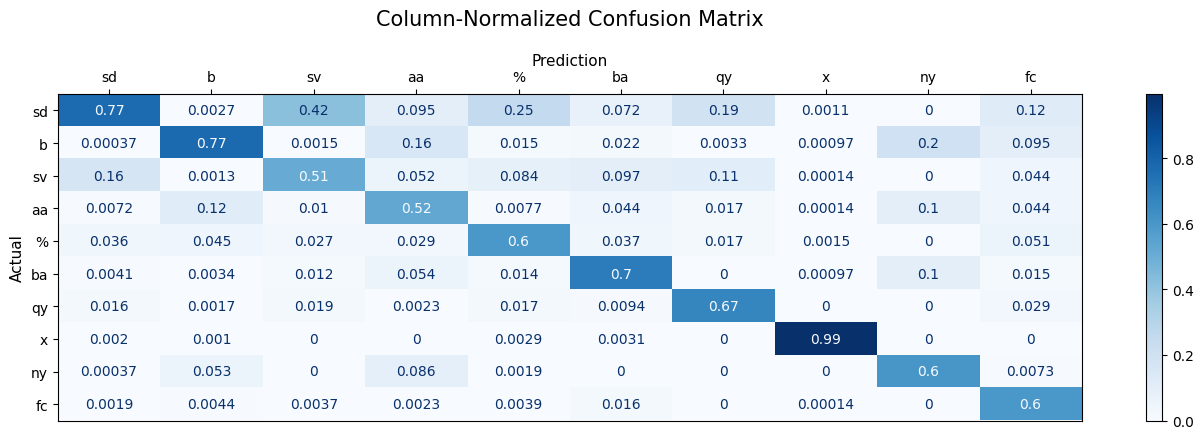

In [25]:
cm=column_cm_normalized
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=da_tags)
disp.plot(cmap=plt.cm.Blues)


plt.title('Column-Normalized Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)


#get current axis
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().set_aspect('auto')
plt.subplots_adjust(left=12, right=14, bottom=0.2)

plt.show()